In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
import matplotlib.gridspec as gridspec 
import pickle
import nibabel as nib
from tvb.simulator.lab import *
import bct as bct
import os
import pickle

# write python dict to a file
output = open('/home/etienne/notebooks/ID_A148_to_Grandj_reduced.pkl', 'rb')
ID_A148_to_Grandj_reduced=pickle.load(output)
output.close()

path ='/home/etienne/data/Grandjean_mouse_fMRI/'
micetable=pd.read_csv(path+'participants.tsv',sep='\s+')

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]


sys.path.insert(0, '/home/etienne')
from src import analysis, simulation  # Import analysis for fcd and clustering
regions=pd.read_csv('modules.csv')
regions["remove_ROI"]=np.isin(regions.index.tolist(),remove_roi)

regions108=regions[regions.remove_ROI==False]
regions108.index=np.arange(108)


regions108['hemisphere']=['Right']*54 + ['Left']*54
regionsorg=regions108.sort_values(by=['hemisphere','module'])

/home/etienne/env/src/tvb-library/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)
<ipython-input-1-4954f026a740>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions108['hemisphere']=['Right']*54 + ['Left']*54


In [2]:
# Import the anatomical structural connectivity.
path='/home/etienne/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(path+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [3]:
def edges_str(Bold):
    return(np.sqrt(np.sum(analysis.go_edge(Bold)**2,axis=1)))

def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def edge_to_FC(edge,n=108):
    
    #Make the Functional Connectivity matrix from an edge
    
    A=np.zeros((n,n))
    triu=np.triu_indices(n, 1)
    A[triu]=edge
    tril=(triu[1],triu[0])
    A[tril]=edge
    A[np.arange(n),np.arange(n)]=[0]*n
    return(A)

In [4]:
path='/home/etienne/data/Grandjean_mouse_fMRI/timeseries/'

bold={}
i=0
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
        bold['%d'%(i+1)]=np.loadtxt(path+filename)
    i+=1

In [5]:
indexwt=micetable[(micetable.genotype=='wild-type')&(micetable.volume==500)].index.tolist()
boldwt={}
for k in indexwt:
    boldwt[str(k)]=bold[str(k)]

In [6]:
Boldwt={}
nregions=148
regcorr=np.arange(nregions)[np.isin(np.arange(nregions),remove_roi)==False]

for j in indexwt:
    volume=bold[str(j)].shape[0]
    bd=np.zeros((volume,nregions))
    for i in range(nregions):
        bd[:,i]=boldwt['%d'%j][:,ID_A148_to_Grandj_reduced['%d'%i]]
    Boldwt['%d'%j]=bd[:,regcorr]

In [7]:
Bolds=[]
for subject in Boldwt.keys():
    B1=Boldwt[subject]
    vol=B1.shape[0]
    for k in range(4):
        b=B1[np.int(k*vol/4):np.int((k+1)*vol/4),:]
        Bolds.append(b)

In [8]:
from scipy.optimize import fsolve,root
from scipy.stats import binom
import cv2

def window(network,delta):
    '''
    Entry: temporal network in the shape nedges x time points
           delta which is the number of time points chosen to average
           
    Return: the unweighted downsampled temporal network of new size (time points)/delta
    '''
    Filter=np.ones((1,delta))

    m=cv2.filter2D(network,-1,Filter)[:,0::delta]
    m[m>0]=1
    return(m)


def Likelihood_activity(a,tau,M):
    #Calculate the set of equation solution of the maximum likelihood estimator with the probability function u(ai,aj)=ai*aj
    
    n=M.shape[0]
    a=a.reshape((n,1))
    amat=np.dot(a,a.T)
    MLmat=(M - tau*amat)/(np.ones((n,n))-amat)
    MLmat[np.eye(n)==1]=0
    F=np.sum(MLmat,1)
    return(F)

def a_init(M,tau):
    #Initialization of the activities of the nodes in order to give to fsolve
    
    n=M.shape[0]
    deg=sum(M,1)/tau
    denom=np.sqrt(np.sum(M)/tau)
    a=np.min([(deg/denom),0.999*np.ones((n))],0)
    return(a)

def backbone(FCbin,tau,alpha=5*1e-2):
    '''
    FCbin is (in principle) the average of the binarized (with a threshold) dFC of one empiric mouse dataset.
    Tau is the number of frames we take into account
    alpha is the confidence level
    
    Gives the most significant edges of the network according to the "Structured backbone of temporal social ties" article technique.
    
    Uses -> Likelihood_activity function to create the function whose root grants the optimal solution
        -> a_init function in order to have a good starting point for the fsolve technique
        -> fsolve function from the scipy.optimize package to find the root of the system of equations
        -> binom.ppf function in order to find the centiles of level alpha and deduce the edges whose activity is higher than expected
        
            -> binom.ppf(cl, n, p) = smallest k such that Prob(X <= k) >= cl, where X is a VA following a binomial distribution of proba p and card n
    '''
    
    cl=1-alpha
    n=FCbin.shape[0]
    
    def func(x):
        return(Likelihood_activity(x,tau=500,M=FCbin))
    
    a_i=a_init(FCbin,500)
    a_opt=fsolve(func,x0=a_i,epsfcn=1e-5)
    a=a_opt.reshape((n,1))
    
    amat=np.dot(a,a.T)      # Probability matrix of the edges (which follows Binomial distribution laws)

    pvalmat=binom.ppf(np.ones(FCbin.shape)*cl,np.ones(FCbin.shape)*tau,amat)     # Calculation of the values to overpass for each edge
    backbone=np.where(FCbin>pvalmat)
    return(backbone)

def jaccard_index(back1,back2):
    '''
    Calculate the Jaccard similarity between two different backbones, which is:
    
    Card(intersection of the backbones)/Card(union of the backbones)
    '''
    Bmat1=np.zeros((n,n))
    Bmat2=np.zeros((n,n))
    Bmat1[back1]=1
    Bmat2[back2]=1

    Bmatint=Bmat1+Bmat2
    jaccard=np.sum(Bmatint>1)/np.sum(Bmatint>0)
    return(jaccard)

def Jac_alt(back1,back2):
    '''
    Modified version of the Jaccard index, where the value calculated is:
    Card(intersection backbones)/min(Card(Backbone1),Card(Backbone2))
    
    It represents how % is the smaller backbone in the bigger backbone
    '''
    
    Bmat1=np.zeros((n,n))
    Bmat2=np.zeros((n,n))
    Bmat1[back1]=1
    Bmat2[back2]=1
    a1=np.sum(Bmat1>0)
    a2=np.sum(Bmat2>0)

    Bmatint=Bmat1+Bmat2
    jaccard=np.sum(Bmatint>1)/np.min([a1,a2])
    return(jaccard)

In [22]:
Backbones=[]
alpha_list=[5e-2,2.5e-2,1e-2,5e-3,2.5e-3,1e-3,5e-4,2.5e-4,1e-4,5e-5,2.5e-5,1e-5,5e-6,2.5e-6,1e-6,5e-7,2.5e-7,1e-7]
factor=9
tau=125
delta=2
alpha=alpha_list[9]
n=108

for k in range(len(Bolds)):
    B1=Bolds[k]
    volume=B1.shape[0]
    constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

    B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
    Edges=analysis.go_edge(B1)

    threshold=factor*np.median(np.abs(Edges))
    Edges_bin=np.zeros(shape=Edges.shape)

    Edges_bin[np.abs(Edges)>threshold]=1
    Edges_w=window(Edges_bin.T,delta).T

    FCbin=edge_to_FC(np.sum(Edges_w,0))


    b=backbone(FCbin,np.round(tau/delta)+1,alpha=alpha)
    Backbones.append(b)

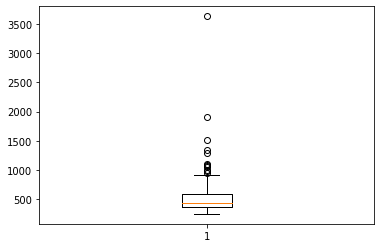

In [23]:
b_len=[]

for k in range(len(Backbones)):
    b_len.append(len(Backbones[k][0]))

plt.boxplot(b_len)
plt.show()

In [35]:
nm=25
Jac_mat=np.zeros((4*nm,4*nm))
Jacalt=np.zeros((4*nm,4*nm))
for i in range(4*nm):
    for j in range(4*nm):
        Jac_mat[i,j]=jaccard_index(Backbones[i+40],Backbones[j+40])
        Jacalt[i,j]=Jac_alt(Backbones[i+40],Backbones[j+40])

<AxesSubplot:>

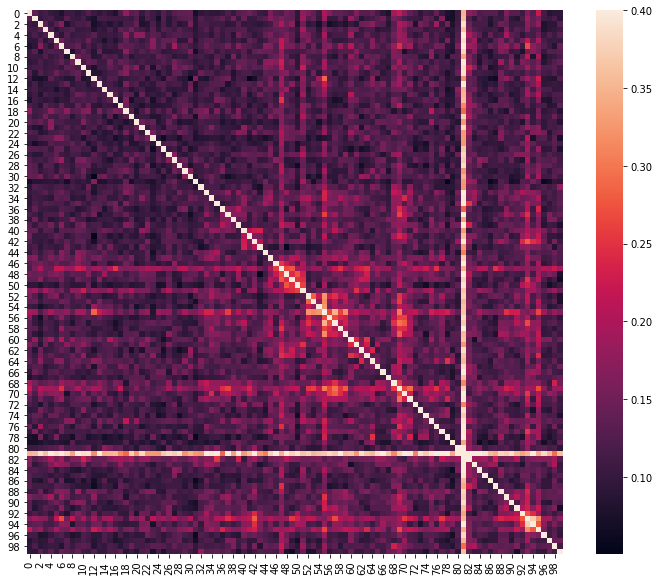

In [36]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(Jacalt,vmax=0.4)

<AxesSubplot:>

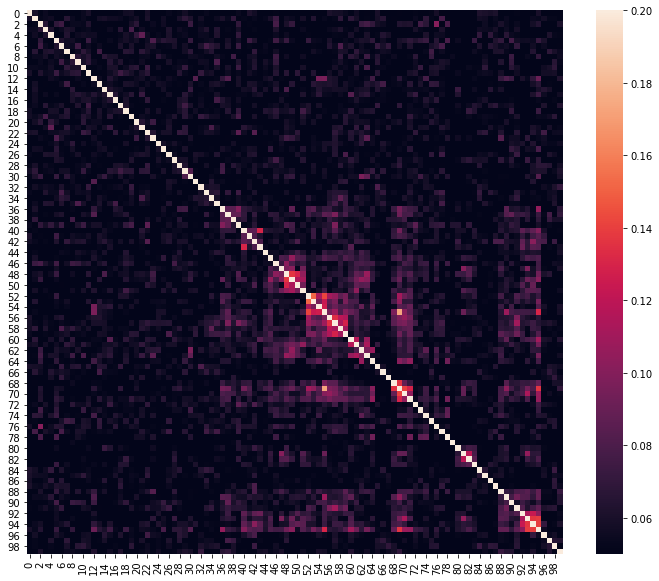

In [37]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(Jac_mat,vmax=0.2,vmin=0.05)

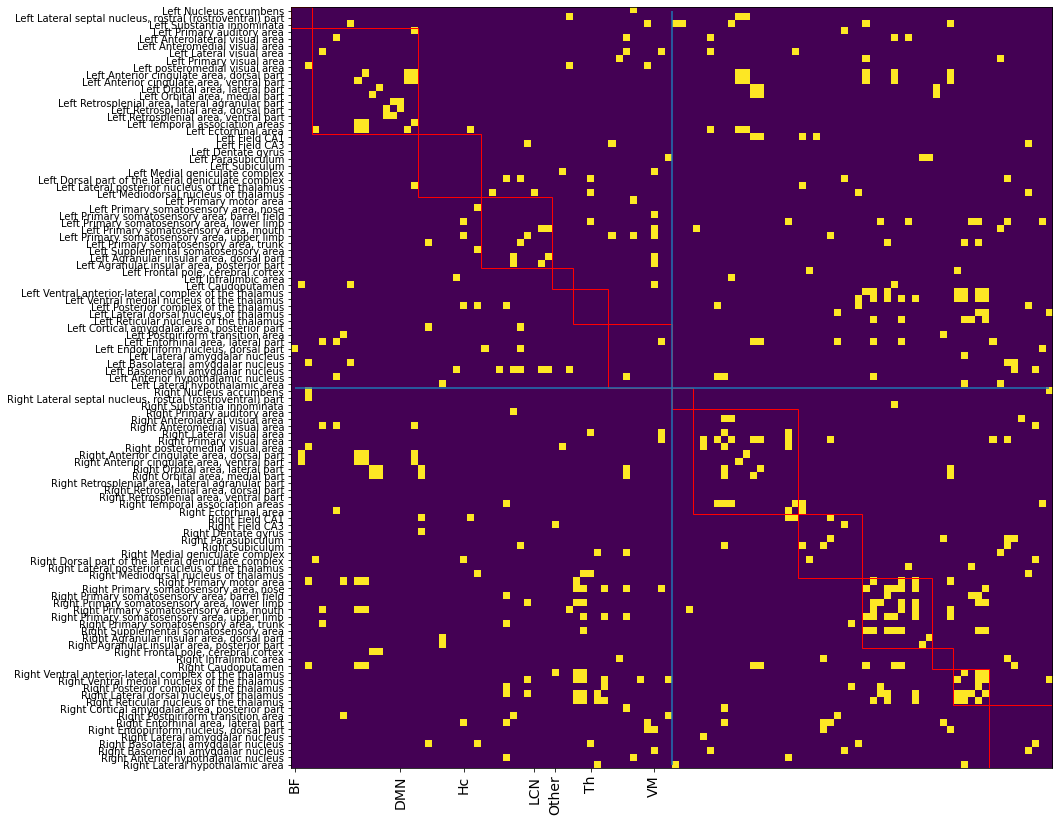

In [31]:
mouse=90

index=regionsorg.index

Bmat=np.zeros((n,n))
Bmat[Backbones[mouse]]=1
test=Bmat[index,:][:,index]

l=regionsorg.groupby('module').nunique().regions/2

plt.figure(figsize=(14,14))
plt.imshow(test)
plt.yticks(range(0, n), regionsorg.regions, fontsize=10, rotation=0)
plt.xticks(np.cumsum(l)-3, np.unique(regionsorg.module), fontsize=14, rotation=90)

plt.hlines(y=53.5,xmin=0,xmax=107)
plt.vlines(x=53.5,ymin=0,ymax=107)


center=0
for i in range(len(l)):
    rectl=plt.Rectangle((center-0.5,center-0.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectl)
    rectr=plt.Rectangle((center+53.5,center+53.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectr)
    center+=l[i]

plt.show()

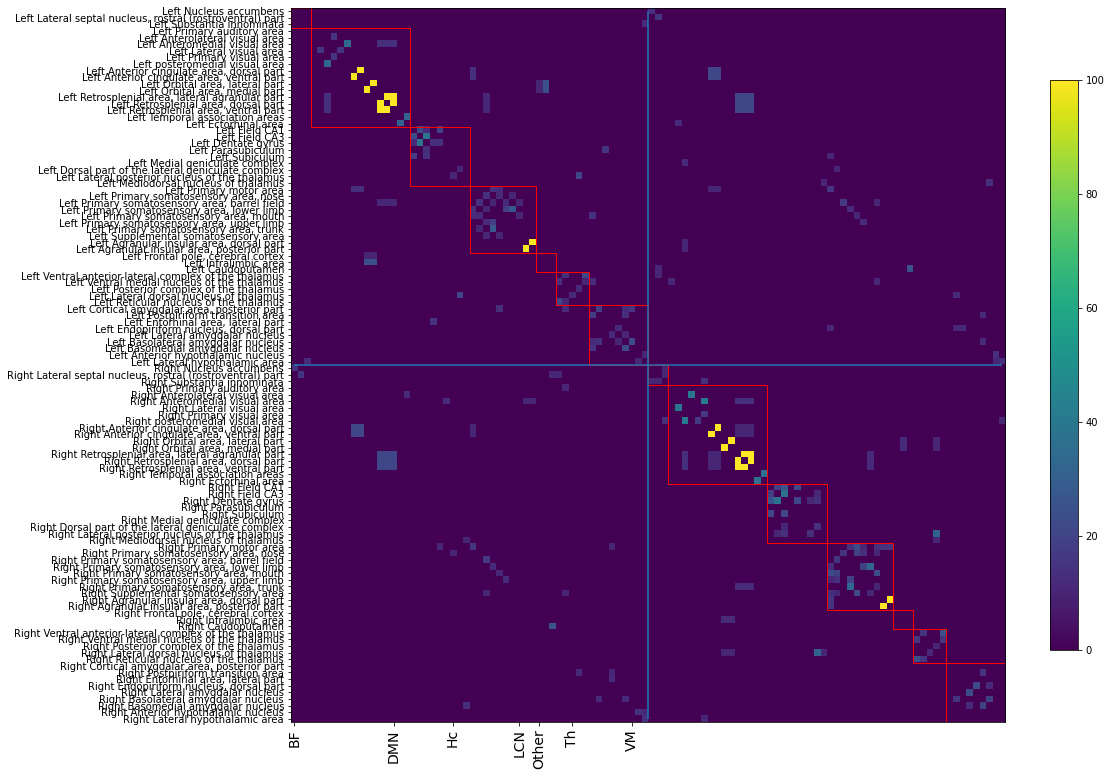

In [83]:
Bagg=np.zeros((n,n))
for k in range(66):  
    Bmat=np.zeros((n,n))
    Bmat[Backbones[k]]=1
    test=Bmat[index,:][:,index]
    Bagg+=test
    
    
Bagg=Bagg*100/66
Bagg[Bagg<10]=0


plt.figure(figsize=(16,14))
plt.imshow(Bagg)
plt.yticks(range(0, n), regionsorg.regions, fontsize=10, rotation=0)
plt.xticks(np.cumsum(l)-3, np.unique(regionsorg.module), fontsize=14, rotation=90)

plt.hlines(y=53.5,xmin=0,xmax=107)
plt.vlines(x=53.5,ymin=0,ymax=107)


l=regionsorg.groupby('module').nunique().regions/2
center=0
for i in range(len(l)):
    rectl=plt.Rectangle((center-0.5,center-0.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectl)
    rectr=plt.Rectangle((center+53.5,center+53.5),l[i],l[i],fc=(0,0,0,0),ec='red')
    plt.gca().add_patch(rectr)
    center+=l[i]

plt.colorbar(shrink=0.75)
plt.show()

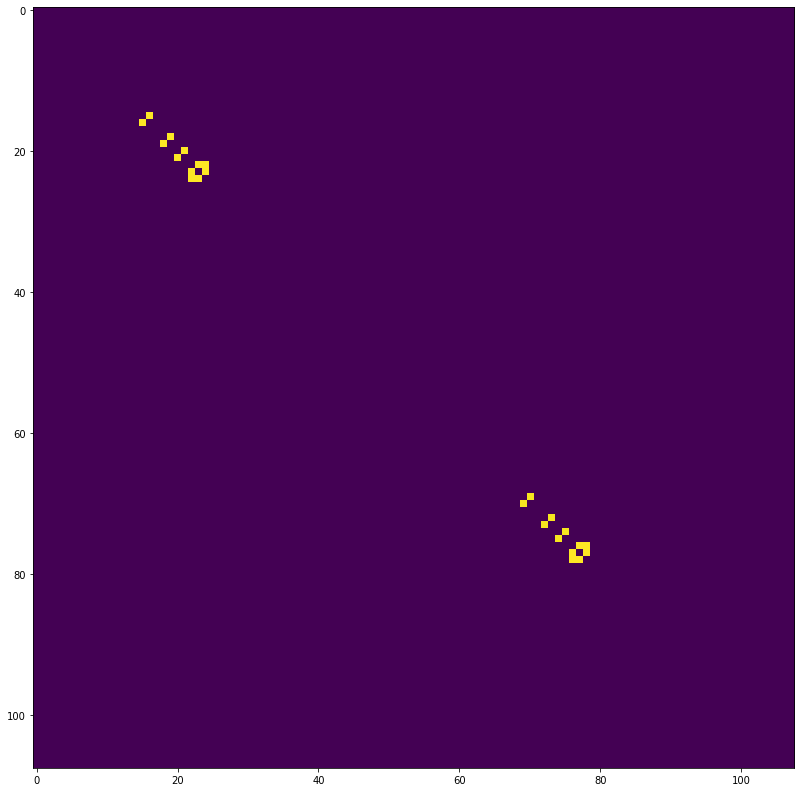

In [84]:
Bagg=np.zeros((n,n))
for k in range(66):  
    Bmat=np.zeros((n,n))
    Bmat[Backbones[k]]=1
    Bagg+=Bmat
    
Bagg=Bagg*100/66
Bagg[Bagg<50]=0

plt.figure(figsize=(16,14))
plt.imshow(Bagg)

In [85]:
np.where(Bagg!=0)

(array([15, 16, 18, 19, 20, 21, 22, 22, 23, 23, 24, 24, 69, 70, 72, 73, 74,
        75, 76, 76, 77, 77, 78, 78]),
 array([16, 15, 19, 18, 21, 20, 23, 24, 22, 24, 22, 23, 70, 69, 73, 72, 75,
        74, 77, 78, 76, 78, 76, 77]))

In [87]:
regions108.iloc[15:25]

,regions,module,remove_ROI,hemisphere
15,"Right Anterior cingulate area, dorsal part",DMN,False,Right
16,"Right Anterior cingulate area, ventral part",DMN,False,Right
17,Right Infralimbic area,Other,False,Right
18,"Right Orbital area, lateral part",DMN,False,Right
19,"Right Orbital area, medial part",DMN,False,Right
20,"Right Agranular insular area, dorsal part",LCN,False,Right
21,"Right Agranular insular area, posterior part",LCN,False,Right
22,"Right Retrosplenial area, lateral agranular part",DMN,False,Right
23,"Right Retrosplenial area, dorsal part",DMN,False,Right
24,"Right Retrosplenial area, ventral part",DMN,False,Right
